In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import catboost as cb
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import datetime
import random

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
#matplotlib.rcParams.update({'font.size': 14})

np.random.seed(9)

# 1. Загрузка данных

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
TRAIN_DATASET_PATH = './data/train.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
TEST_DATASET_PATH = './data/test.csv'
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [4]:
train_df[train_df.Square>157.6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
403,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
1449,11764,93,3.0,169.117203,NaN,1.0,5,3.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B,211325.577641
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
2790,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253
3204,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663
4444,5602,93,3.0,169.385184,NaN,1.0,2,10.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B,190949.293998
5258,10678,17,4.0,170.016872,NaN,0.0,12,0.0,1977,0.093443,B,B,23,4635,5,3300.0,2,4,B,531049.721966


In [5]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# 2. EDA и очистка данных

Распределение стоимости выглядит предсказуемо:

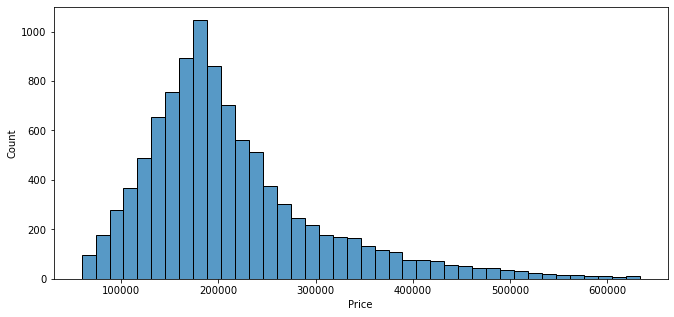

In [6]:
plt.figure(figsize=(11,5))
sns.histplot(train_df.Price, bins=40)
plt.show()

In [7]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [8]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [10]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [11]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [12]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

##### Square

In [13]:
np.quantile(train_df.Square, q=0.9975), np.quantile(train_df.Square, q=0.002)

(151.16260817737495, 19.925535701033183)

In [14]:
train_df[train_df.Square>180].shape[0], train_df[train_df.Square<27].shape[0]

(11, 47)

Очень мало квартир с огромной площадью и слишком маленькой. Квартир менее 27 кв.м., наверное, не существует. Нижнюю границу обозначу числом 27. Не квантилем, а именно числом, чтобы еще заполнить вычислением пропуски LifeSquare и не уйти при этом в минус.

In [15]:
square_max = np.quantile(train_df.Square, q=0.9975)
train_df.loc[train_df.Square>square_max, 'Square'] = square_max
train_df.loc[train_df.Square<27, 'Square'] = 27

##### Rooms

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [18]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### KitchenSquare

In [19]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [20]:
train_df['KitchenSquare'].quantile(.975)

13.0

In [21]:
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [22]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

##### HouseFloor, Floor

In [23]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [24]:
condition = (train_df['HouseFloor'].isna()) | (train_df['HouseFloor'] == 0)
train_df.loc[condition, 'HouseFloor'] = train_df['HouseFloor'].median()

In [25]:
condition = (train_df['Floor'].isna()) | (train_df['Floor'] > train_df['HouseFloor'])
train_df.loc[condition, 'Floor'] = train_df.loc[condition, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [26]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### HouseYear

In [27]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [28]:
current_year = datetime.date.today().year
train_df.loc[train_df.HouseYear>current_year, 'HouseYear'] = current_year

In [29]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Обработка пропусков

##### LifeSquare
Не жилая площадь - это кухня, коридоры, ванная и туалет, лоджия. Есть значение площади кухни, остальное в сумме еще две кухни примерно или чуть меньше. Буду вычитать 2.5 кухни из общей площади Square и заполнять пропуски LifeSquare

In [30]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())

In [31]:
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] * 2.5

In [32]:
np.quantile(train_df.LifeSquare, q=0.025), np.quantile(train_df.LifeSquare, q=0.975)

(14.517301320482677, 82.93505275367978)

In [33]:
life_square_min = np.quantile(train_df.LifeSquare, q=0.025)
life_square_max = np.quantile(train_df.LifeSquare, q=0.975)

train_df.loc[train_df.LifeSquare>life_square_max, 'LifeSquare'] = life_square_max
train_df.loc[train_df.LifeSquare<life_square_min, 'LifeSquare'] = life_square_min

##### Healthcare_1
Можно восставновить пропуски Healthcare_1.
Если выполнять сортировку по различным признакам, то пропуски Healthcare группируются в блоки.
Отсюда предположение, что значения отсутствуют для отдельных районов или комплексов.

<AxesSubplot:>

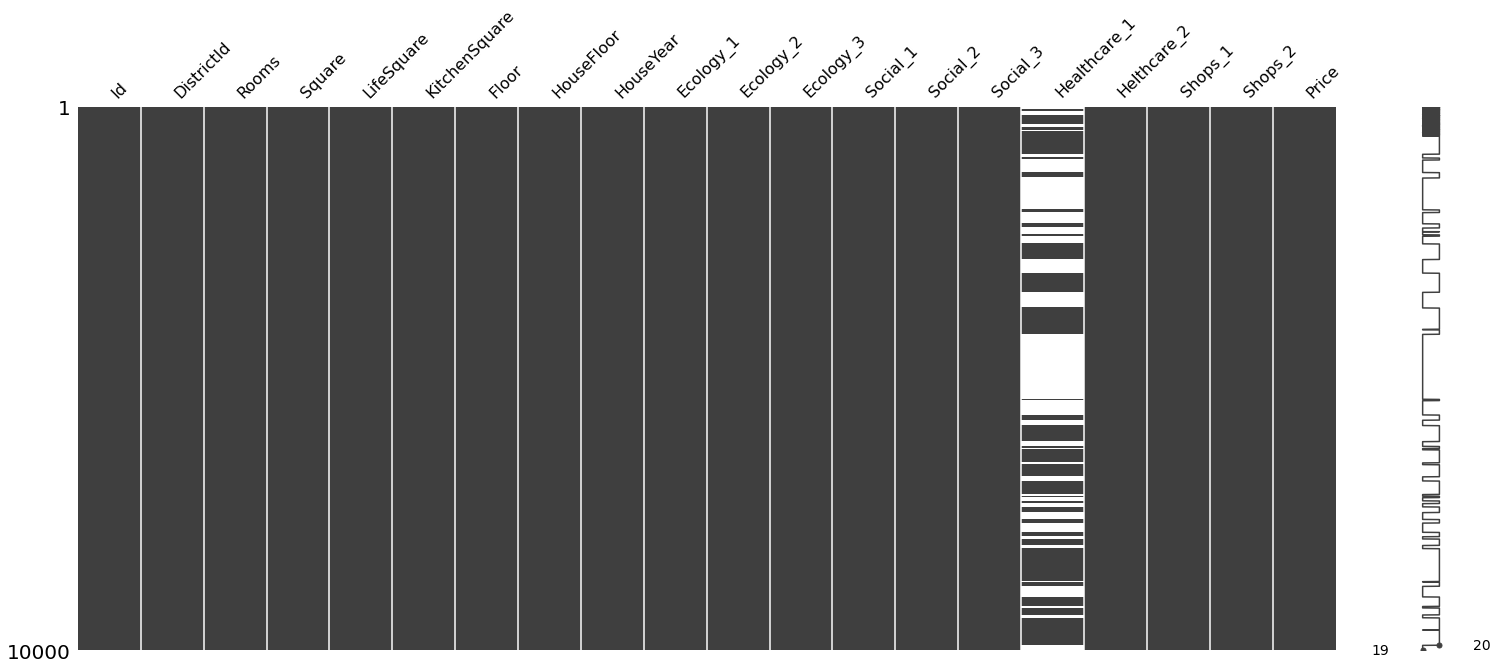

In [34]:
import missingno as msno

msno.matrix(train_df.sort_values('Ecology_1'))

Некоторые признаки содержат значения A и B. Заменим на 0 и 1, чтобы модели могли работать с этими признаками:

In [35]:
def get_dummies(df):
    binary_to_numbers = {'A': 0, 'B': 1}

    df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
    df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
    df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)
    
    return df

train_df = get_dummies(train_df)

С помощью KNNImputer ищу похожие строки, в которых совпадает большинство значений. Заполняю пропуски значениями из этих строк. Если на тесте будут пропуски по другим признакам из списка, то и они будут заполнены.

In [36]:
ratings_features = ['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Healthcare_1',
                    'Helthcare_2', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Shops_2']

knn_imp = KNNImputer(n_neighbors=2)
knn_imp.fit(train_df[ratings_features])
train_df[ratings_features] = (pd.DataFrame(knn_imp.transform(train_df[ratings_features]), columns=ratings_features)).values

### Новые признаки

##### DistrictSize
Размер района по количеству квартир:

In [37]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                                        .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [38]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27.0,3.0,115.027311,82.935053,10.0,4,10.0,2014,0.075424,...,1.0,11.0,3097.0,0.0,2802.5,0.0,0.0,1.0,305018.871089,851
1,3013,22.0,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1.0,30.0,6207.0,1.0,1183.0,1.0,0.0,1.0,177734.553407,78
2,8215,1.0,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1.0,33.0,5261.0,0.0,240.0,3.0,1.0,1.0,282078.720850,652


##### MeanPriceMeter
В разных районах цены сильно отличаются. Считаю среднюю стоимость квадратного метра по районам:

In [39]:
mean_price_meter = train_df[['DistrictId', 'Square', 'Price']]
mean_price_meter['MeanPriceMeter'] = mean_price_meter['Price'] / mean_price_meter['Square']
mean_price_meter = mean_price_meter.groupby(['DistrictId'], as_index=False).agg({'MeanPriceMeter':'median'})

train_df = train_df.merge(mean_price_meter, on='DistrictId', how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,MeanPriceMeter
0,11809,27.0,3.0,115.027311,82.935053,10.0,4,10.0,2014,0.075424,...,11.0,3097.0,0.0,2802.5,0.0,0.0,1.0,305018.871089,851,2761.685392
1,3013,22.0,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30.0,6207.0,1.0,1183.0,1.0,0.0,1.0,177734.553407,78,3553.678687
2,8215,1.0,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33.0,5261.0,0.0,240.0,3.0,1.0,1.0,282078.720850,652,3251.647396


##### Social
Social_1 и Social_2 сильно коррелируют. Сделаю из них один признак.

Text(0.5, 1.0, 'Корреляция признаков')

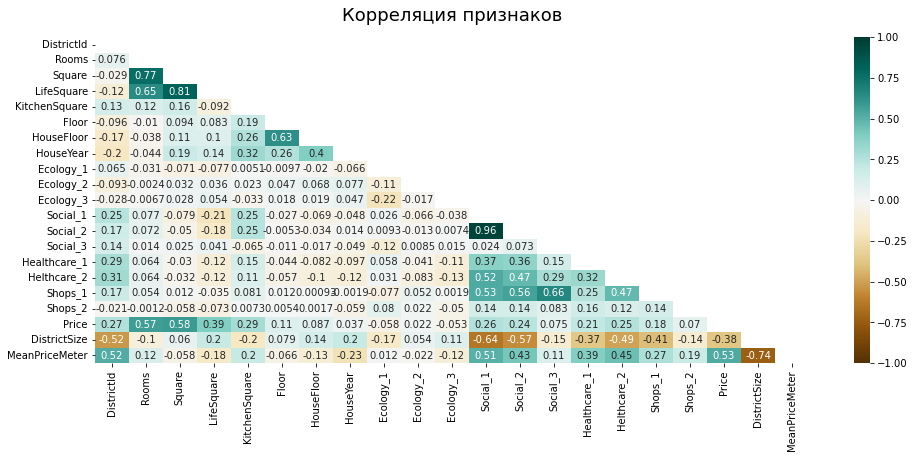

In [40]:
plt.figure(figsize=(16, 6)) 

mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(train_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Корреляция признаков', fontdict={'fontsize':18}, pad=16)

In [41]:
r_scaler = RobustScaler()
colnames = ['Social_1', 'Social_2']

train_df[colnames] = pd.DataFrame(r_scaler.fit_transform(train_df[colnames]), columns=colnames)

pca = PCA(n_components=1, random_state=11)

train_df['Social_1_2'] = pca.fit_transform(train_df[colnames])
train_df.drop(colnames, axis=1, inplace=True)

In [42]:
class DataPreparation():

    def __init__(self):
        
        self.medians = None
        self.square_max = None
        self.life_square_min = None
        self.life_square_max = None
        self.kitchen_square_quantile = None
        self.current_year = None
        self.binary_to_numbers = None
        self.ratings_features = None
        self.knn_imp = None
        self.r_scaler = RobustScaler()
        self.pca = PCA(n_components=1, random_state=11)
        
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.mean_price_meter = None
        
        
    def fit(self, X):   
        
        self.medians = X.median()
        self.square_max = np.quantile(X.Square, q=0.9975)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(0.975)
        self.life_square_min = np.quantile(X.LifeSquare, q=0.025)
        self.life_square_max = np.quantile(X.LifeSquare, q=0.975)
        self.current_year = datetime.date.today().year
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.ratings_features = ['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Healthcare_1',
                           'Helthcare_2', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Shops_2']
        
        self.knn_imp = KNNImputer(n_neighbors=3)
        self.knn_imp.fit(X[self.ratings_features])       
        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        self.mean_price_meter = X[['DistrictId', 'Square', 'Price']]
        self.mean_price_meter['MeanPriceMeter'] = self.mean_price_meter['Price'] / self.mean_price_meter['Square']
        self.mean_price_meter = self.mean_price_meter.groupby(['DistrictId'], as_index=False).agg({'MeanPriceMeter':'median'})
       
  
    def transform(self, X):

        # Square
        X.loc[X.Square>self.square_max, 'Square'] = self.square_max
        X.loc[X.Square<27, 'Square'] = 27

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
            
        # LifeSquare
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] * 2.5
        
        X.loc[X.LifeSquare<self.life_square_min, 'LifeSquare'] = self.life_square_min
        X.loc[X.LifeSquare<self.life_square_min, 'LifeSquare'] = self.life_square_min
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # Ratings     
        X[self.ratings_features] = (pd.DataFrame(self.knn_imp.transform(X[self.ratings_features]), columns=self.ratings_features)).values
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')        
        X['DistrictSize'].fillna(5, inplace=True)
        
        # MeanPriceMeter
        X = X.merge(self.mean_price_meter, on='DistrictId', how='left')
        X['MeanPriceMeter'].fillna(X['MeanPriceMeter'].median(), inplace=True)
        
        
        
        # Social
        colnames = ['Social_1', 'Social_2']
        X[colnames] = pd.DataFrame(self.r_scaler.fit_transform(X[colnames]), columns=colnames)
        X['Social_1_2'] = self.pca.fit_transform(X[colnames])
        X.drop(colnames, axis=1, inplace=True)
        
        X.drop(['Id', 'DistrictId'], axis=1, inplace=True)

        X.fillna(self.medians, inplace=True)
        
        if 'Price' in X.columns:
            X.drop(['Price'], axis=1, inplace=True)
            #condition = ((X['Square'] * X['MeanPriceMeter']) < (X['Price'] / 2)) | ((X['Square'] * X['MeanPriceMeter']) > (X['Price'] * 2))
            #X.loc[condition, 'Price'] = X.loc[condition, 'Square'] * X.loc[condition, 'MeanPriceMeter']
        
        return X

# 3. Создание и обучение моделей

Функция для расчета R2, кроссвалидации и создания графиков соответсвия прогнозов реальным ценам:

In [43]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values, model):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=100))
    print(f'cv_score: {cv_score}')
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Создание датасетов для обучения и валидации:

In [44]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

target = train_df['Price']

X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, test_size=0.33, shuffle=True, random_state=21)

In [45]:
X_train = get_dummies(X_train)

In [46]:
preparation = DataPreparation()

preparation.fit(X_train)

X_train = preparation.transform(X_train)
X_valid = preparation.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 18), (3300, 18))

Первая рассматриваемая модель CatBoostRegressor:

In [47]:
cat_model = cb.CatBoostRegressor(loss_function='RMSE',
                                 eval_metric = 'R2',
                                 random_state=100,
                                 iterations=300,
                                 depth=5,
                                 l2_leaf_reg=7,
                                 learning_rate=0.025,
                                 grow_policy= 'Lossguide',
                                 max_leaves = 100,
                                 verbose=False
                                )
cat_model.fit(X_train, y_train)

Train R2:	0.805
Test R2:	0.749
cv_score: [0.70982092 0.76853818 0.74994912]


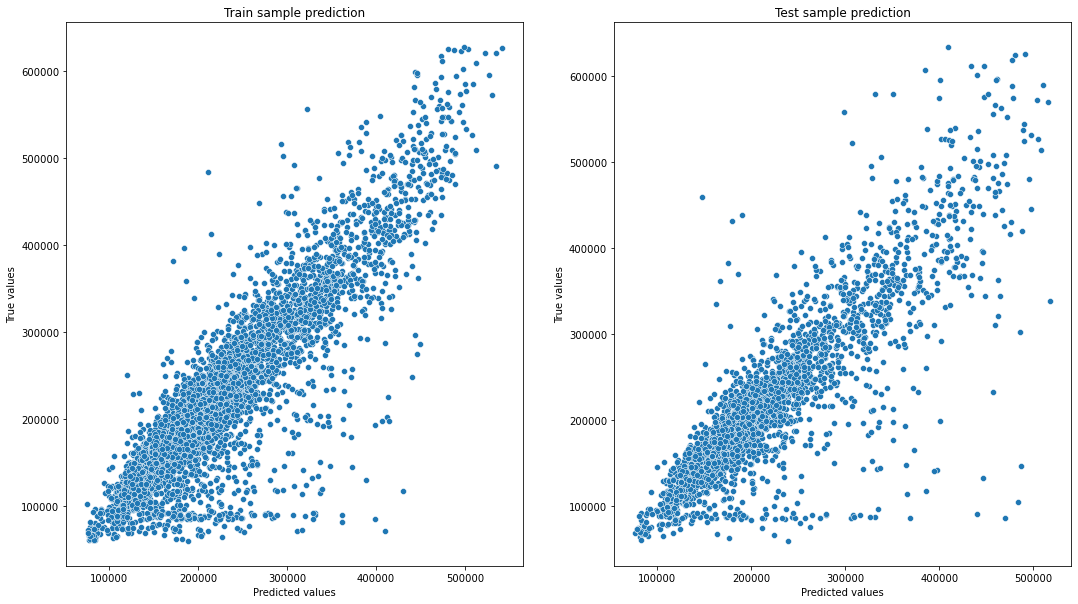

In [48]:
y_train_preds = cat_model.predict(X_train)
y_test_preds = cat_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds, cat_model)

Другая модель - XGBRegressor:

In [49]:
xgb_model = XGBRegressor(random_state=100,
                         max_depth=6,
                         n_estimators=400,
                         eta = 0.018,
                         reg_lambda=7,
                         min_child_weight=100
                        )

xgb_model.fit(X_train, y_train)
xgb_model.get_booster().get_score(importance_type='weight')

{'Rooms': 135.0,
 'Square': 1320.0,
 'LifeSquare': 395.0,
 'KitchenSquare': 220.0,
 'Floor': 302.0,
 'HouseFloor': 425.0,
 'HouseYear': 790.0,
 'Ecology_1': 392.0,
 'Ecology_3': 3.0,
 'Social_3': 308.0,
 'Healthcare_1': 263.0,
 'Helthcare_2': 110.0,
 'Shops_1': 138.0,
 'DistrictSize': 267.0,
 'MeanPriceMeter': 1337.0,
 'Social_1_2': 387.0}

Train R2:	0.792
Test R2:	0.748
cv_score: [0.70520852 0.75811283 0.74393717]


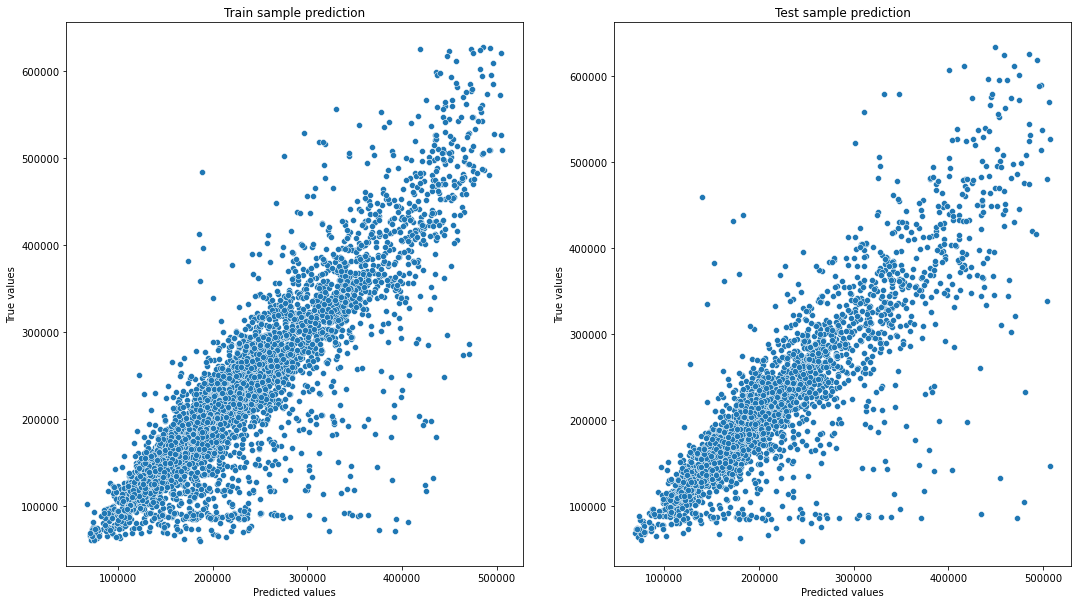

In [50]:
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds, xgb_model)

Модели дают примерно одинаковые предсказания. Можно использовать любую

In [51]:
train_df = get_dummies(train_df)
preparation.fit(train_df)
target = train_df['Price']

train_df = preparation.transform(train_df)
test_df = preparation.transform(test_df)

X_train.shape, X_valid.shape

((6700, 18), (3300, 18))

In [52]:
cat_model.fit(train_df, target)

cv_score = cross_val_score(cat_model, train_df, target, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=100))
print(f'cv_score: {cv_score}')

cv_score: [0.73743448 0.73717172 0.77316281]


In [53]:
xgb_model.fit(train_df, target)

cv_score = cross_val_score(xgb_model, train_df, target, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=100))
print(f'cv_score: {cv_score}')

cv_score: [0.73385746 0.73652594 0.76987995]


In [54]:
SAMPLE_SUBMISSION = './data/sample_submission.csv'
cat_submit = pd.read_csv(SAMPLE_SUBMISSION, sep=',')
xgb_submit = pd.read_csv(SAMPLE_SUBMISSION, sep=',')

In [55]:
pred_cat = cat_model.predict(test_df)
pred_xgb = xgb_model.predict(test_df)

In [56]:
cat_submit['Price'] = pred_cat
xgb_submit['Price'] = pred_xgb

In [57]:
cat_submit.to_csv('./data/cat_submit_5.csv', index=False)
xgb_submit.to_csv('./data/xgb_submit_5.csv', index=False)

In [58]:
cat_submit.shape, xgb_submit.shape

((5000, 2), (5000, 2))

Файлы с предсказаниями готовы. Теперь небольшой итог. Сильнее всего на стоимость влияет площадь. Имеются квартиры, у которых цена отличается в 2 раза от средней по району.

In [59]:
train_df['Price'] = target

condition = ((train_df.Square * train_df.MeanPriceMeter) < (train_df.Price / 1.8)) | \
            ((train_df.Square * train_df.MeanPriceMeter) > (train_df.Price * 1.8))

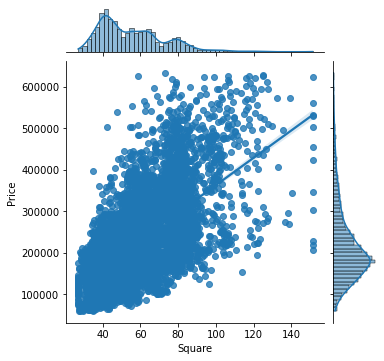

In [60]:
grid = sns.jointplot(train_df.loc[~condition, 'Square'], train_df.loc[~condition, 'Price'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

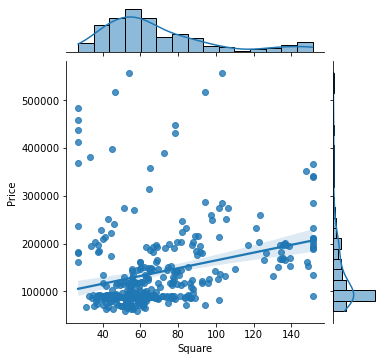

In [61]:
grid = sns.jointplot(train_df.loc[condition, 'Square'], train_df.loc[condition, 'Price'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

На верхнем графике цены близкие к рыночным. На нижнем сильно отличающиеся. Видно, что огромная часть квартир с заниженой ценой. Вероятно это такой способ ухода от уплаты налогов (в договоре полцены, а остальное в обход). Можно как-то еще охарактеризовать эти объекты. Но рассматривать их вместе с остальными не нужно.
Стоит поискать и другие группы. Возможно, каким-то кваритрам назначили не тот район. А мы имеем много оценок, которые зависят от района (экология, социальные и др.).